<a href="https://colab.research.google.com/github/cliche-niche/model-zoo-submissions/blob/main/RepVGG/RepVGG1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An implementation of [RepVGG](https://arxiv.org/pdf/2101.03697.pdf), A0 architecture. It tests upon CIFAR-10 dataset.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers

Loading the data, subtracting the mean, and applying horizontal flip augmentation.

In [15]:
(trainIm, trainLab), (testIm, testLab) = tf.keras.datasets.cifar10.load_data()
trainIm = trainIm / 255.0
testIm = testIm / 255.0

trainImMean = np.mean(trainIm, axis=0)
trainIm -= trainImMean
testIm -= trainImMean


trainIm = tf.image.random_crop(trainIm, trainIm.shape)
# tf.image.random_flip_left_right(trainIm)

trainLab = tf.keras.utils.to_categorical(trainLab, 10)
testLab = tf.keras.utils.to_categorical(testLab, 10)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
datagen.fit(trainIm)

Code of a single stage.

The first layer of a stage down-samples the input using 3x3 convolutions (stride=2, padding=1) and 1x1 convolutions (stride=2, no padding), adds them and applies ReLU activation on their sum.

The rest of the layers use 3x3 conv (stride=1, padding=1), 1x1 conv (stride=1, no padding). Then the output of these layers is added along with an identity, and ReLU activation is applied.

At the end of a stage, BatchNormalization is applied.

In [16]:
class stage(layers.Layer):
    def __init__(self, filters, layer):
        super(stage, self).__init__()
        self.dow3 = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))
        self.dow1 = layers.Conv2D(filters, kernel_size=1, strides=2, kernel_regularizer=regularizers.l2(1e-4))
        self.con3 = layers.Conv2D(filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4))
        self.con1 = layers.Conv2D(filters, kernel_size=1, padding='same', kernel_regularizer=regularizers.l2(1e-4))
        self.bn = layers.BatchNormalization()
        self.re = layers.Activation(activations.relu)
        self.lay = layer

    def call(self, inp):
        x = self.dow3(inp)
        y = self.dow1(inp)
        x = x + y
        x = self.re(x)
        for i in range(self.lay-1):
            y = self.con3(x)
            z = self.con1(x)
            x = x + y + z
            x = self.re(x)
        x = self.bn(x)
        return x


An implementation of RepVGG-A0 model. 5 stages are used with widths `[min(64, 64a), 64a, 128a, 256a, 512b]` and number of layers `[1, 2, 4, 14, 1]` respectively, and `a=0.75` and `b=2.5`. The 5 stages are then followed by GlobalAveragePooling layer and a fully connected layer with 10 channels (for CIFAR-10).

In [17]:
class repvgg(tf.keras.Model):
    def __init__(self, a, b, l=[1,2,4,14,1]):
        super(repvgg, self).__init__()
        self.st1 = stage(min(64, 64*a), 1)
        self.st2 = stage(64*a, 2)
        self.st3 = stage(128*a, 4)
        self.st4 = stage(256*a, 14)
        self.st5 = stage(512*b, 1)
        self.gap = layers.GlobalAveragePooling2D()
        self.end = layers.Dense(10, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))
        

    def call(self, inp):
        x = self.st1(inp)
        x = self.st2(x)
        x = self.st3(x)
        x = self.st4(x)
        x = self.st5(x)
        x = self.gap(x)
        x = self.end(x)

        return x


    def model(self, train):
        x = layers.Input(shape=train[0].shape)
        return tf.keras.Model(inputs=x, outputs=self.call(x))

In [18]:
model = repvgg(a=0.75, b=2.5)
model.compile(  optimizer = tf.keras.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [19]:
#For callbacks
class mcb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
       if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
cb = mcb()

In [20]:
history = model.fit(datagen.flow(trainIm, trainLab, batch_size=256), epochs=60, validation_data=(testIm, testLab), callbacks=[cb])
# history = model.fit(trainIm, trainLab, batch_size=256, epochs=60, validation_data=(testIm, testLab), callbacks=[cb], shuffle=True)

Epoch 1/60
196/196 [==============================] - 16s 68ms/step - loss: 2.0163 - accuracy: 0.3156 - val_loss: 4.9172 - val_accuracy: 0.1000
Epoch 2/60
196/196 [==============================] - 13s 64ms/step - loss: 1.7649 - accuracy: 0.3868 - val_loss: 2.9541 - val_accuracy: 0.2251
Epoch 3/60
196/196 [==============================] - 12s 63ms/step - loss: 1.5664 - accuracy: 0.4799 - val_loss: 68.7644 - val_accuracy: 0.1000
Epoch 4/60
196/196 [==============================] - 12s 63ms/step - loss: 1.4409 - accuracy: 0.5316 - val_loss: 1.7161 - val_accuracy: 0.4663
Epoch 5/60
196/196 [==============================] - 12s 62ms/step - loss: 1.3066 - accuracy: 0.5811 - val_loss: 3.2235 - val_accuracy: 0.3163
Epoch 6/60
196/196 [==============================] - 12s 62ms/step - loss: 1.2219 - accuracy: 0.6142 - val_loss: 1.5739 - val_accuracy: 0.5378
Epoch 7/60
196/196 [==============================] - 13s 66ms/step - loss: 1.1303 - accuracy: 0.6485 - val_loss: 1.4570 - val_accuracy

Achieves an accuracy of **78.03%** on CIFAR-10 test dataset, with 89.81% accuracy on training dataset.

In [21]:
model.evaluate(testIm, testLab)

313/313 [==============================] - 2s 7ms/step - loss: 1.2877 - accuracy: 0.7435


[1.287716269493103, 0.7434999942779541]

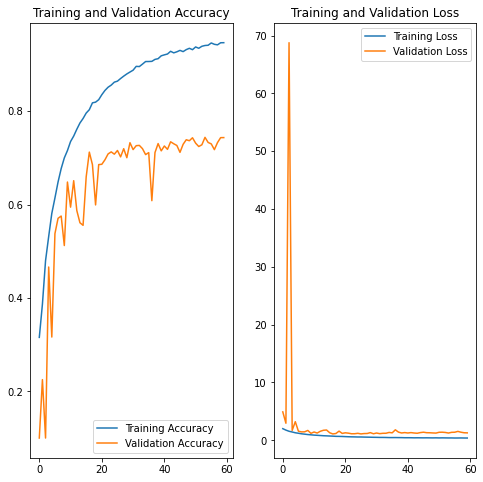

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
print(model.model(trainIm).summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage_10 (stage)             (None, 16, 16, 48)        1728      
_________________________________________________________________
stage_11 (stage)             (None, 8, 8, 48)          46464     
_________________________________________________________________
stage_12 (stage)             (None, 4, 4, 96)          139008    
_________________________________________________________________
stage_13 (stage)             (None, 2, 2, 192)         554496    
_________________________________________________________________
stage_14 (stage)             (None, 1, 1, 1280)        2465280   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0     